# Operator Performance Visualization

## Data Import

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

from prepare_calibration_data import parse_hyrise_csv

In [2]:
def import_operator_data(path, filename):
    if not path.endswith(os.sep):
        path += os.sep
    operator_data = parse_hyrise_csv(path + filename)
    table_data = parse_hyrise_csv(path + "table_meta.csv")
    columns_data = parse_hyrise_csv(path + "column_meta.csv")
    chunk_meta = parse_hyrise_csv(path + "segment_meta.csv")
        
    joined_data = operator_data.merge(table_data, on=["TABLE_NAME"], how="left")
    joined_data.fillna('', inplace=True)
    joined_data = joined_data.merge(columns_data, on=["TABLE_NAME", "COLUMN_NAME"], how="left")

    # only look at the encoding of the first chunk
    chunkrows = chunk_meta.loc[(chunk_meta["CHUNK_ID"] == 0)]
    joined_data = joined_data.merge(chunkrows, on=["TABLE_NAME", "COLUMN_NAME"], how="left")

    joined_data = joined_data.rename(
        columns={"CHUNK_SIZE": "MAX_CHUNK_SIZE", "COLUMN_DATA_TYPE": "DATA_TYPE", "ENCODING_TYPE": "ENCODING"}
    )

    # remove the rows with ExpressionEvaluator queries from the test data since we don't have any in the test data
    joined_data = joined_data.loc[(joined_data["OPERATOR_IMPLEMENTATION"] != "ExpressionEvaluator")]

    # explicitly add selectivity
    input_rows_left = "INPUT_ROWS"
    if "INPUT_ROWS_LEFT" in joined_data: 
        input_rows_left = "INPUT_ROWS_LEFT"
        joined_data["SELECTIVITY_RIGHT"] = joined_data["OUTPUT_ROWS"] / joined_data["INPUT_ROWS_RIGHT"]
        joined_data["SELECTIVITY_RIGHT"].fillna(0, inplace=True)
    joined_data["SELECTIVITY_LEFT"] = joined_data["OUTPUT_ROWS"] / joined_data[input_rows_left]
    joined_data["SELECTIVITY_LEFT"].fillna(0, inplace=True)

    # remove infinite selectivities from empty inputs
    joined_data.replace(np.inf, 0, inplace=True)
    joined_data.fillna("0", inplace=True)
    return joined_data

TRAINING_DATA_PATH = os.path.join('..', 'cmake-build-release', 'data', 'train', '')

general_operator_data = import_operator_data(TRAINING_DATA_PATH, 'operators.csv')
join_data = parse_hyrise_csv(TRAINING_DATA_PATH + 'joins.csv')
join_stages = parse_hyrise_csv(TRAINING_DATA_PATH + 'join_stages.csv')
join_stages = join_stages.merge(join_data, on=["JOIN_ID"], how="left")

C:\Users\Daniel\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Generate Runtime Matrices for Operators

In [3]:
def runtime_matrix(operator_name, data, dimensions, y_axis = "RUNTIME_NS"):
    colors = cm.get_cmap("tab10")(np.arange(10))
    x_axes = [column for column in list(data.columns) if column not in dimensions + [y_axis]]
    dimension_labels = []
    for dimension in dimensions:
        if dimension == "combined":
            dimension_labels.append("\ncombined")
        else:
            dimension_labels += [f"{dimension}\n{value}" for value in data[dimension].unique()]
    plt.rcParams["figure.figsize"] = [4 * len(dimension_labels), 3 * len(x_axes)]
    fig, axes = plt.subplots(nrows=len(x_axes), ncols=len(dimension_labels))
    fig.suptitle(f"{operator_name}, max. run-time {round(np.amax(data[y_axis])/1000.0)} ms", size=16)
    dimension_index = 0
    axis_max = np.amax(data[y_axis]) * 1.05
    for dimension in dimensions:
        if dimension == "combined":
            values = ["combined"]
        else:
            values = data[dimension].unique()
            values.sort()
        for value in values:
            plot_data = data if dimension == "combined" else data[data[dimension] == value]
            plot_index = 0
            for x_axis in x_axes:
                plot = axes[plot_index] if len(dimension_labels) == 1 else axes[plot_index][dimension_index]
                plot_index += 1
                plot_data = plot_data.sort_values(by=x_axis, axis=0)
                plot.scatter(plot_data[x_axis], plot_data[y_axis], c=[colors[dimension_index]])
                plot.set_ylim([0, axis_max])
                plot.set_yticklabels([])
            dimension_index += 1
    if len(dimension_labels) > 1:
        for plot, plot_title in zip(axes[0], dimension_labels):
            plot.set_title(plot_title)
    outer_left_plots = axes if len(dimension_labels) == 1 else axes[:,0]
    for plot, y_label in zip(outer_left_plots, x_axes):
        plot.set_ylabel(y_label, rotation=90)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

## Operators with one Input

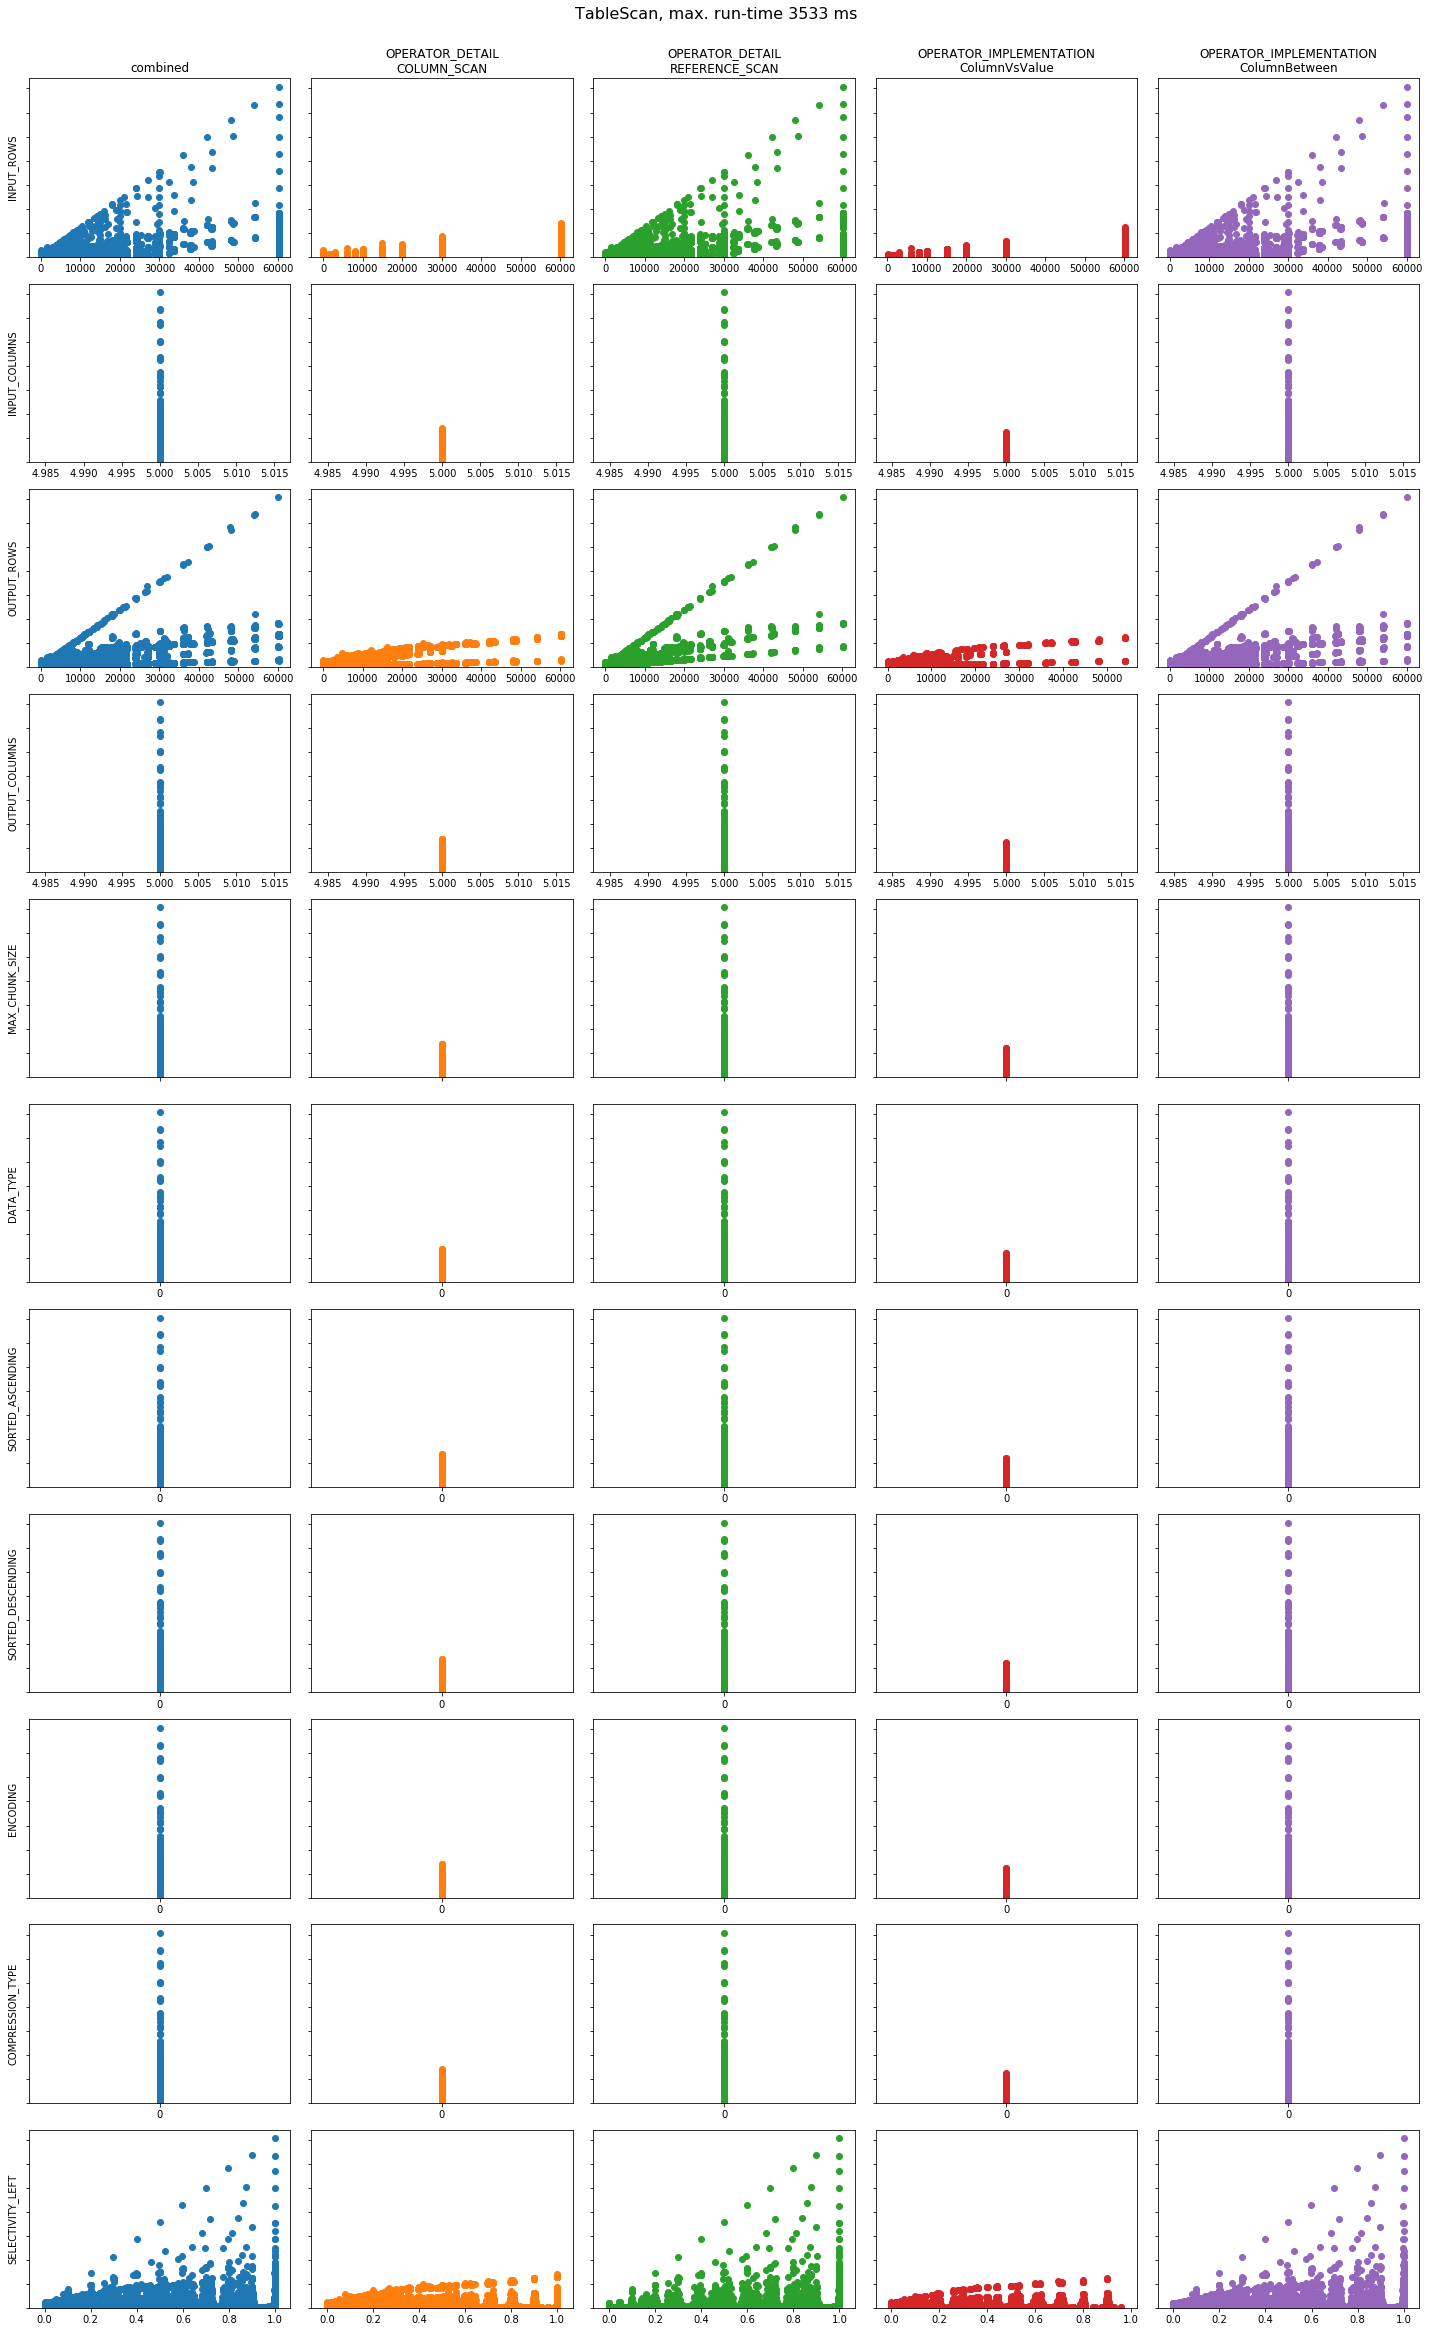

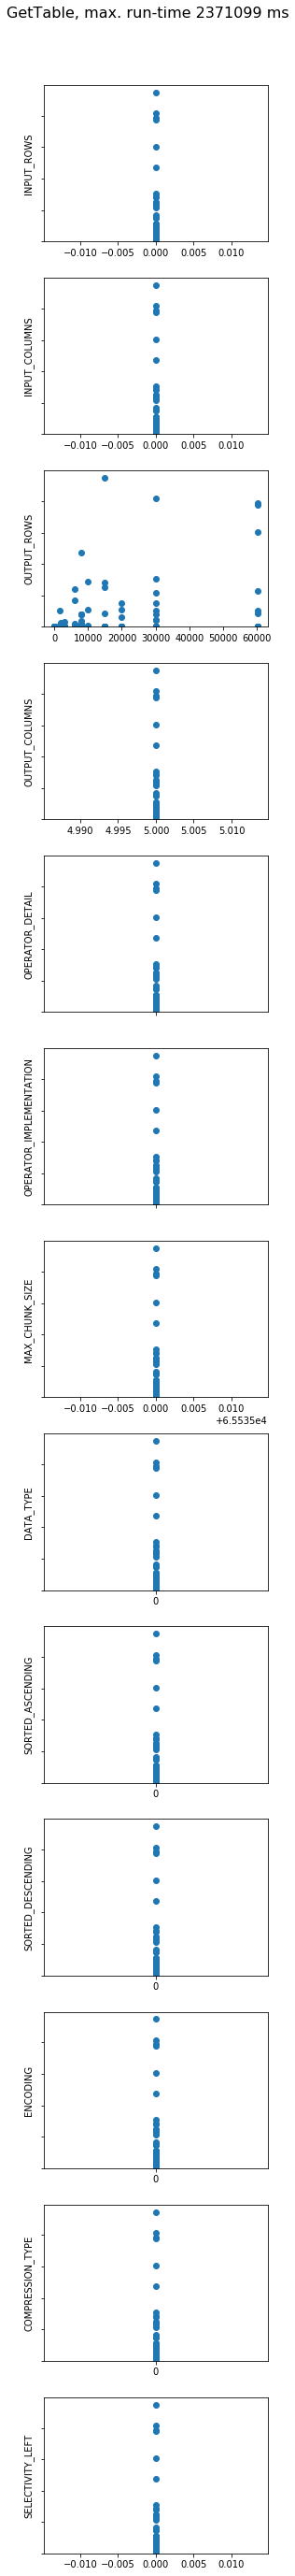

In [4]:
for operator in general_operator_data["OPERATOR_NAME"].unique():
    current_data = general_operator_data[general_operator_data.OPERATOR_NAME.eq(operator)]
    current_data = current_data.drop(labels=["OPERATOR_NAME", "TABLE_NAME", "COLUMN_NAME", "ROW_COUNT", "CHUNK_ID"], axis=1)
    dimensions = ["combined"]
    for dimension in ["OPERATOR_DETAIL", "OPERATOR_IMPLEMENTATION"]:
        if len(current_data[dimension].unique()) > 1:
            dimensions.append(dimension)
    runtime_matrix(operator, current_data, dimensions)

## Joins

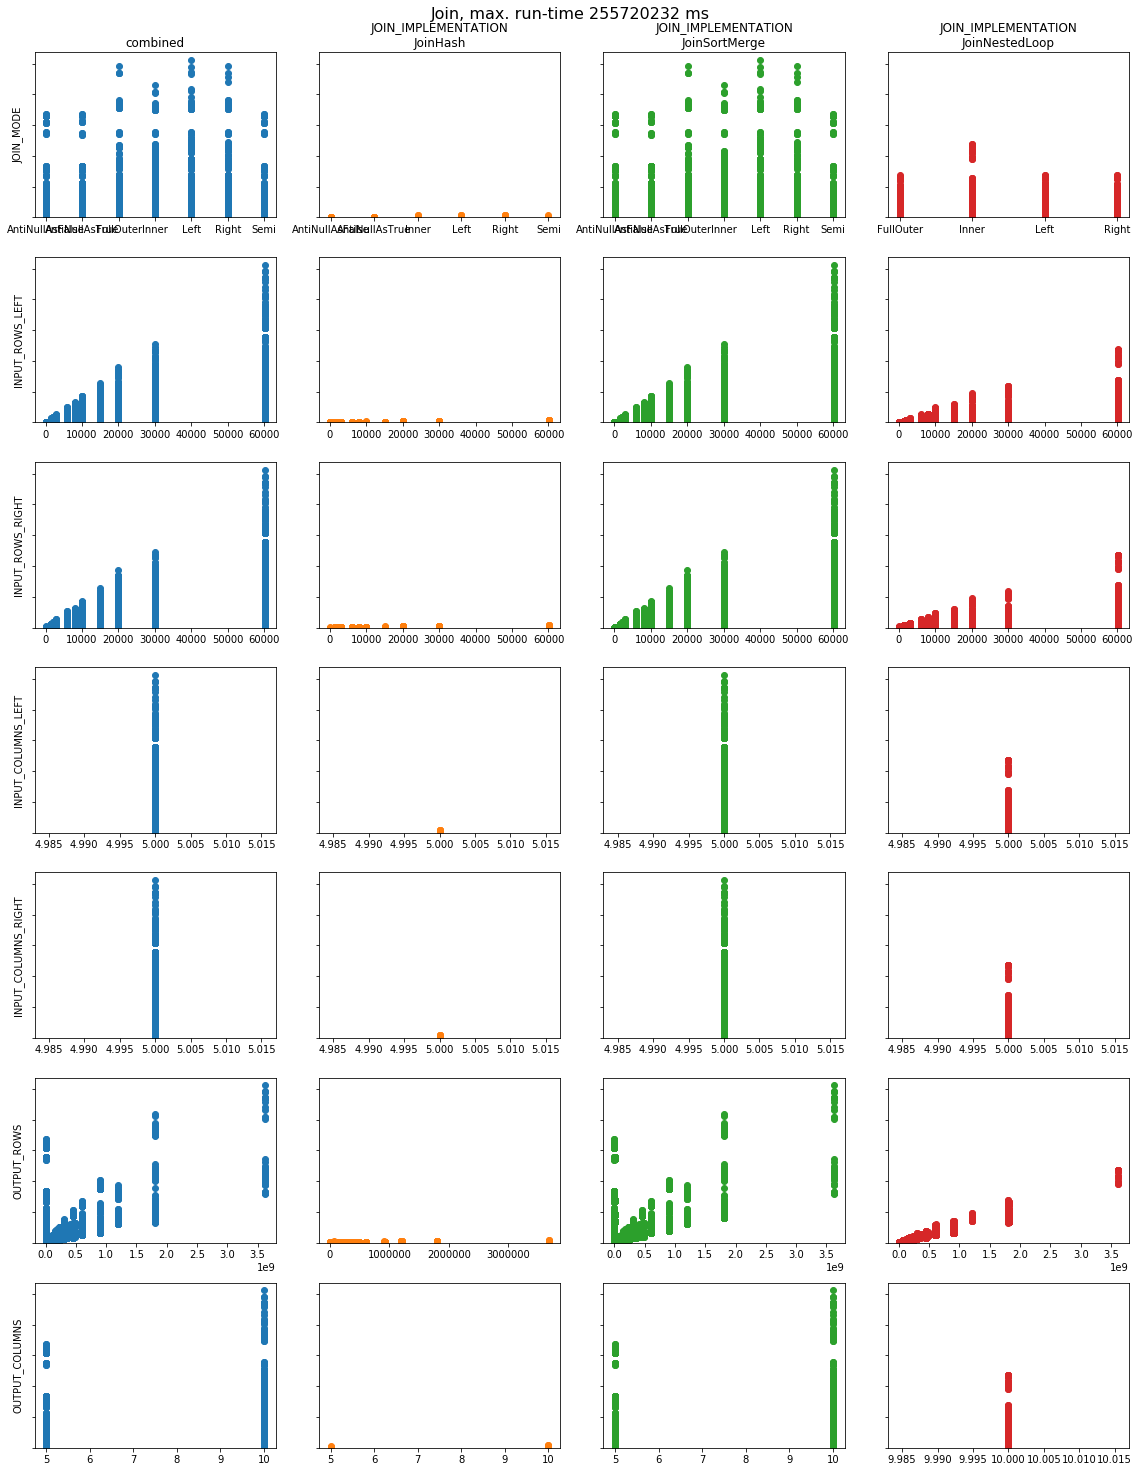

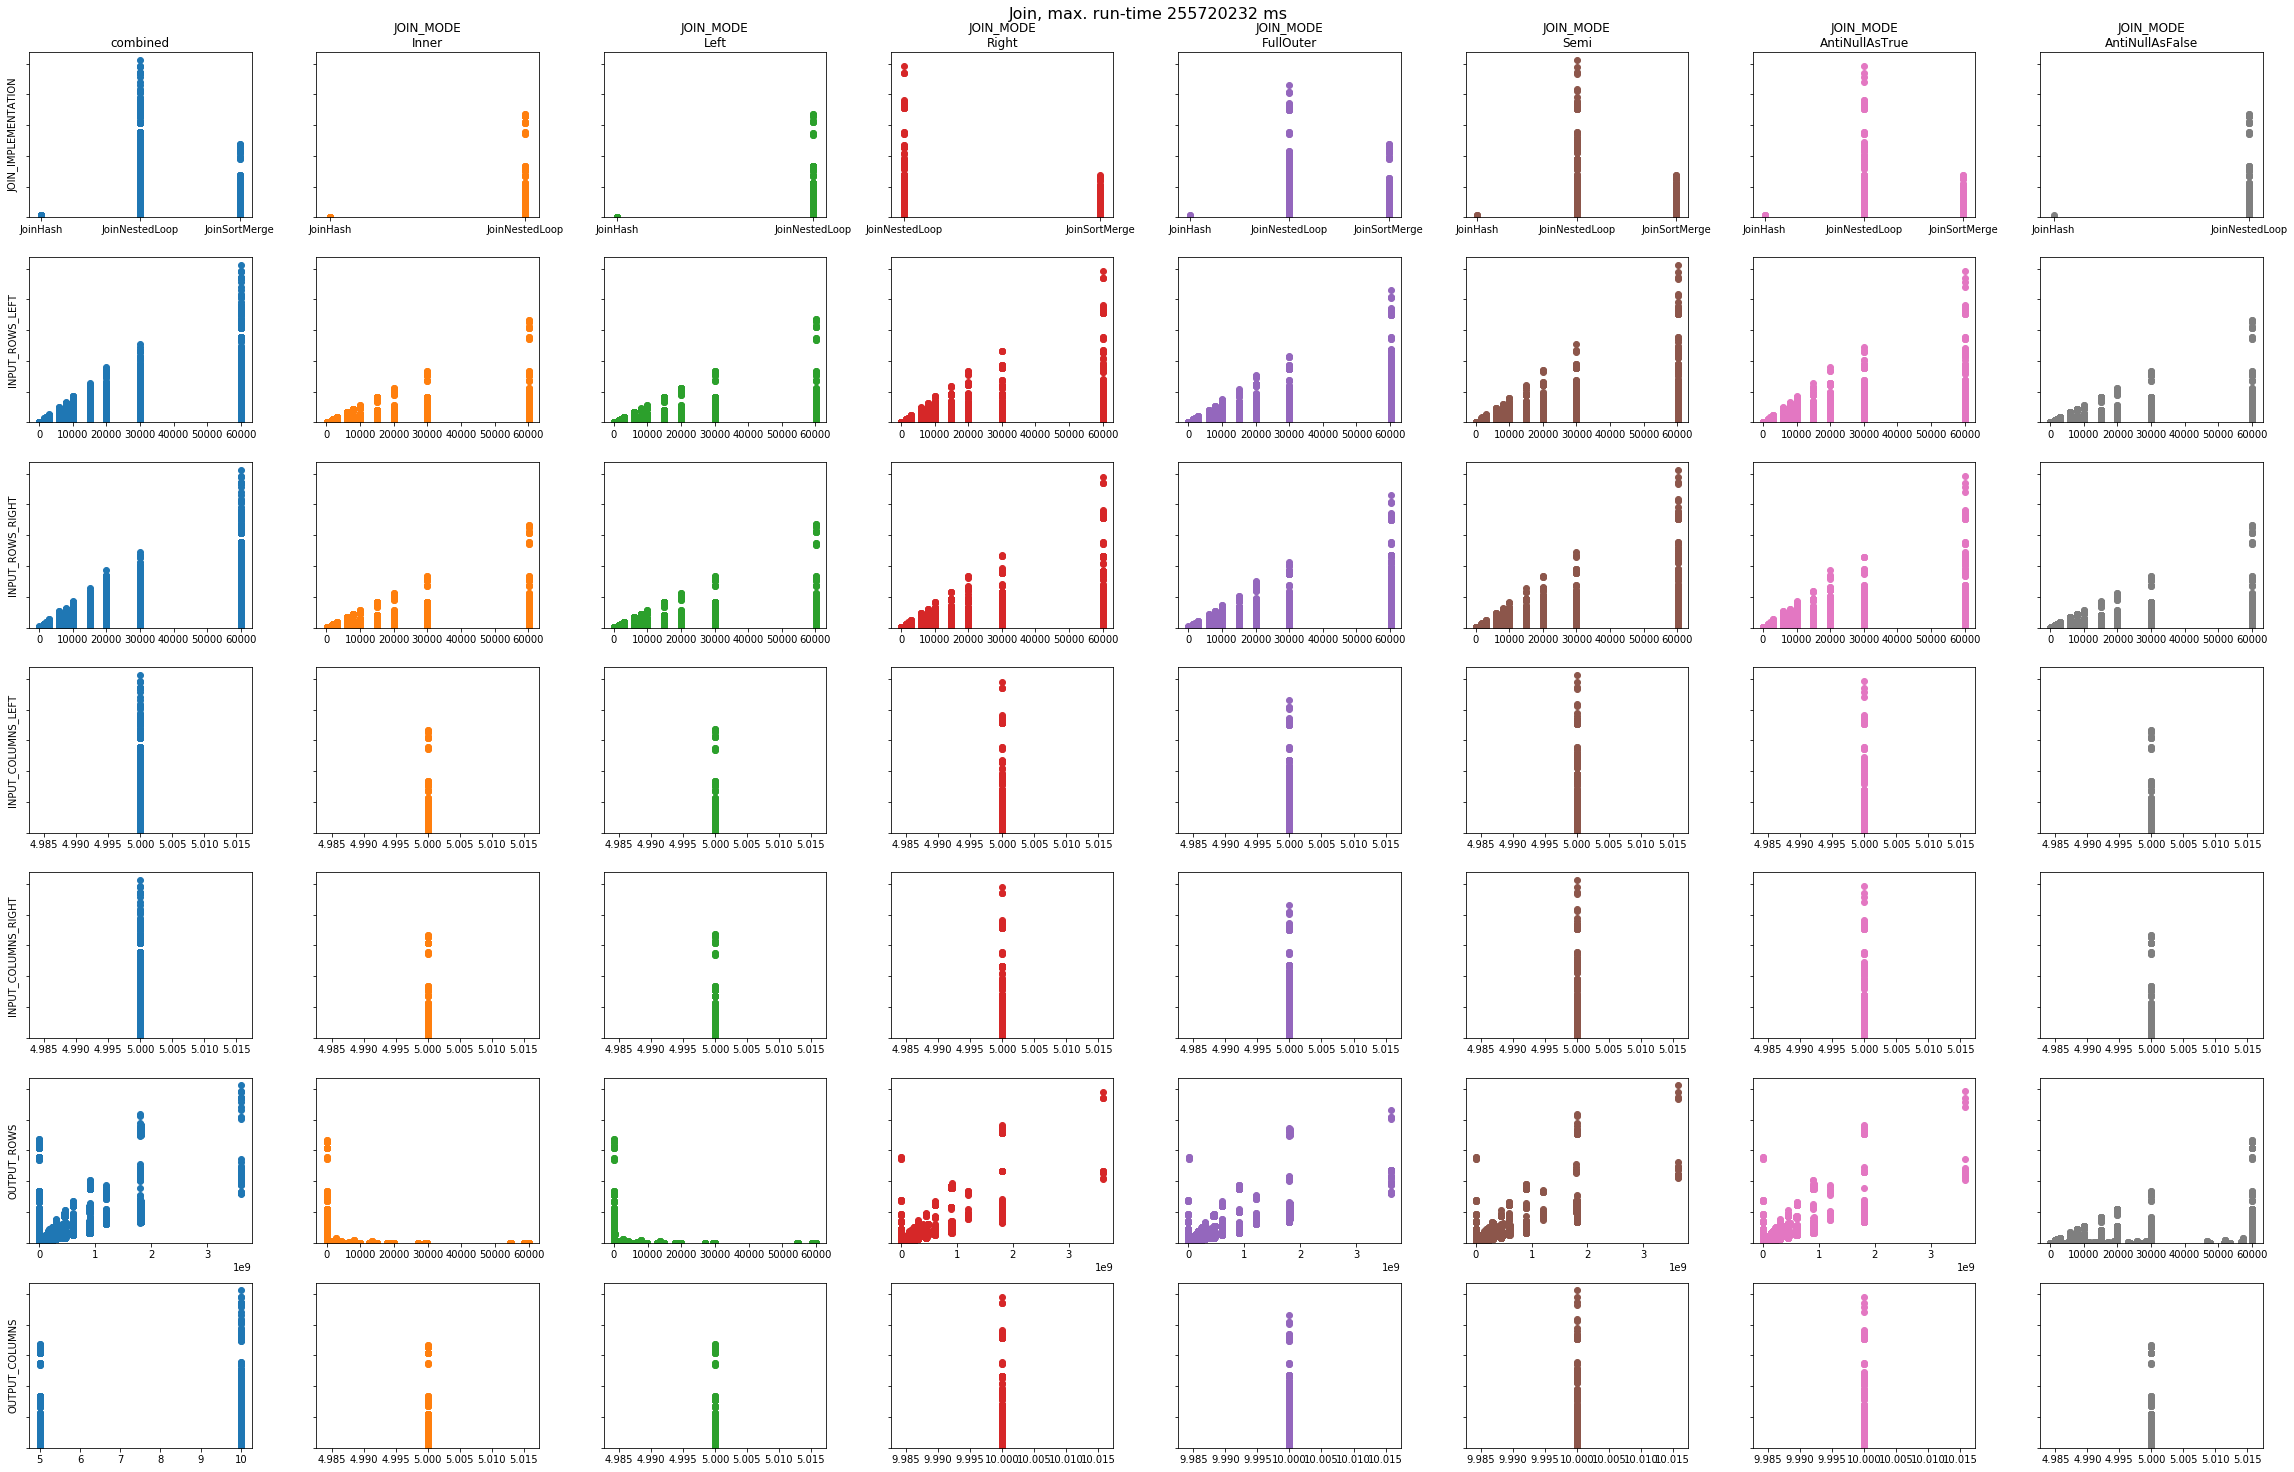

In [5]:
plot_join_data = join_data.drop(labels=["LEFT_TABLE_NAME", "RIGHT_TABLE_NAME", "LEFT_COLUMN_NAME", "RIGHT_COLUMN_NAME", "JOIN_ID"], axis=1)
join_impl_dimensions = ["combined", "JOIN_IMPLEMENTATION"]
runtime_matrix("Join", plot_join_data, join_impl_dimensions)
join_mode_dimensions = ["combined", "JOIN_MODE"]
runtime_matrix("Join", plot_join_data, join_mode_dimensions)

## Join Stages

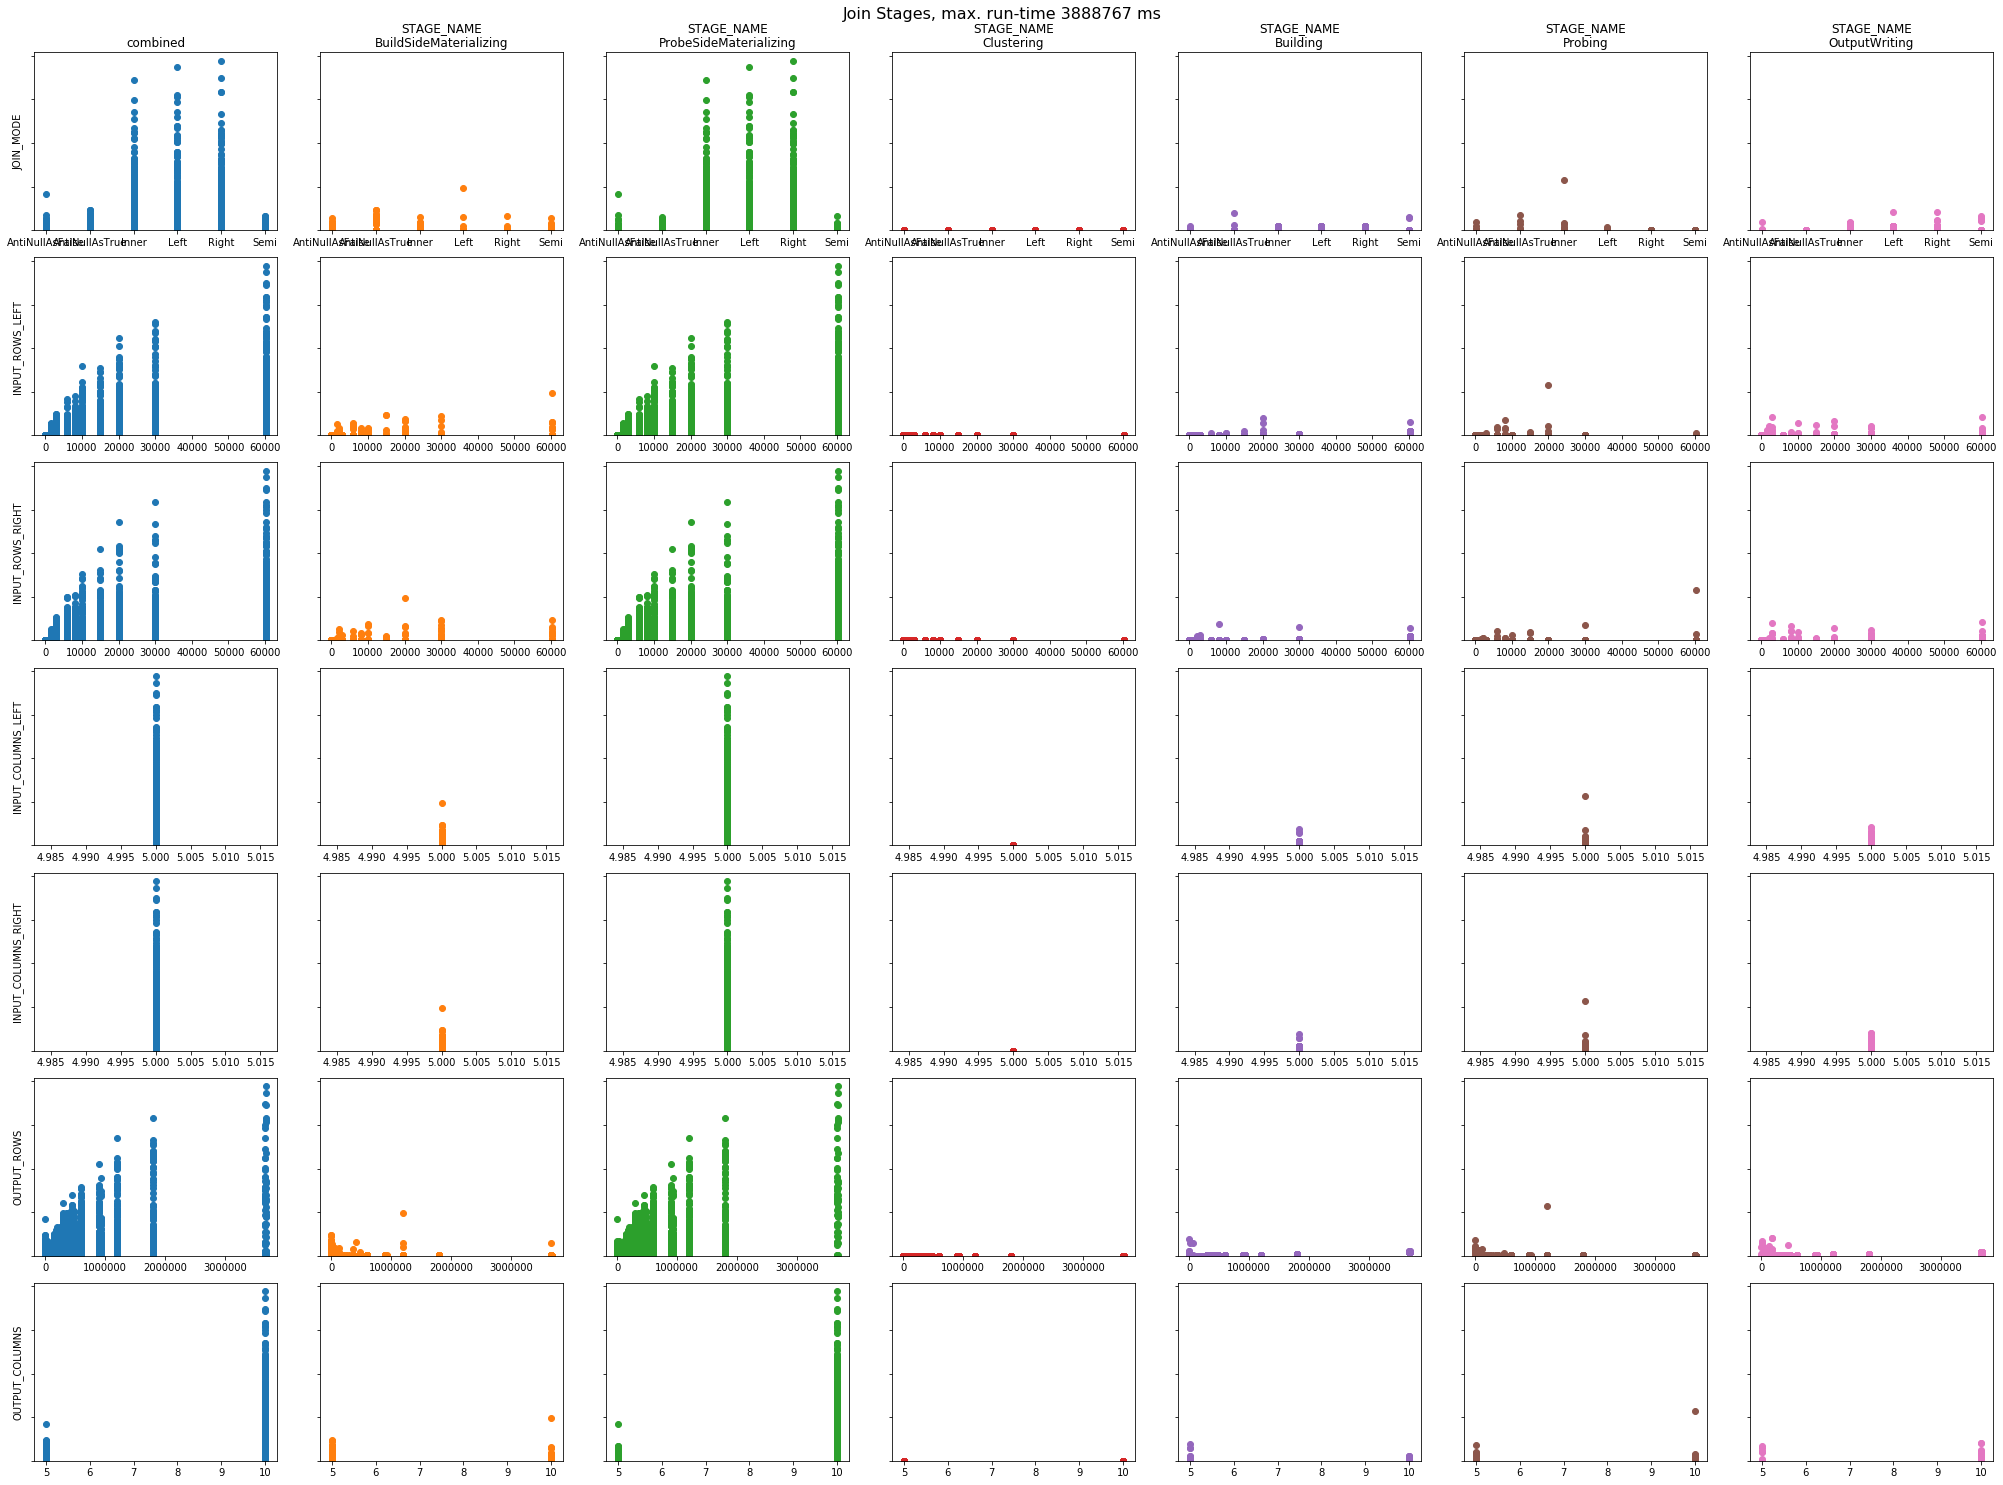

In [8]:
plot_join_stages = join_stages.drop(labels=["RUNTIME_NS_y", "JOIN_IMPLEMENTATION", "LEFT_TABLE_NAME", "RIGHT_TABLE_NAME", "LEFT_COLUMN_NAME", "RIGHT_COLUMN_NAME", "JOIN_ID"], axis=1)
join_stage_dimensions = ["combined", "STAGE_NAME"]
runtime_matrix("Join Stages", plot_join_stages, join_stage_dimensions, y_axis="RUNTIME_NS_x")